In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from natsort import natsorted

In [2]:
# Set Image parameters
im_width = 256
im_height = 256
border = 5

In [144]:
ids = next(os.walk("/home/emu/data_final/unet/images_colored/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  1750


In [8]:
from natsort import natsorted

In [141]:
# Validation folder images
ids_val = next(os.walk("/home/emu/data_final/unet/validation/patient_8_validation/"))[2] # list of names all images in the given path
print("No. of images = ", len(ids_val))

No. of images =  220


In [145]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [131]:
ids_val = natsorted(ids_val)

In [132]:
X_val = np.zeros((len(ids_val), im_height, im_width, 1), dtype=np.float32)

In [133]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_val), total=len(ids_val)):
    # Load images
    img = load_img("/home/emu/data_final/unet/validation/patient_7_validation/"+id_, grayscale=True)
    print("/home/emu/data_final/unet/validation/patient_7_validation/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    
    # Save images
    X_val[n] = x_img/255.0

/home/emu/data_final/unet/validation/patient_7_validation/0.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/1.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/2.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/3.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/4.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/5.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/6.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/7.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/8.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/9.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/10.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/11.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/12.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/13.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/14.jpeg
/home/emu/data_final

/home/emu/data_final/unet/validation/patient_7_validation/155.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/156.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/157.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/158.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/159.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/160.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/161.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/162.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/163.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/164.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/165.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/166.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/167.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/168.jpeg
/home/emu/data_final/unet/validation/patient_7_validation/169.

In [53]:
X_val[1].shape

(256, 256, 1)

In [146]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/home/emu/data_final/unet/images_colored/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode = 'constant', preserve_range = True)
    
    # Load masks
    mask = img_to_array(load_img("/home/emu/data_final/unet/masks_colored/"+id_, grayscale=True))
    mask = resize(mask, (256, 256, 1), mode = 'constant', preserve_range = True)
    
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/home/emu/.conda/envs/keras/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [147]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Mask')

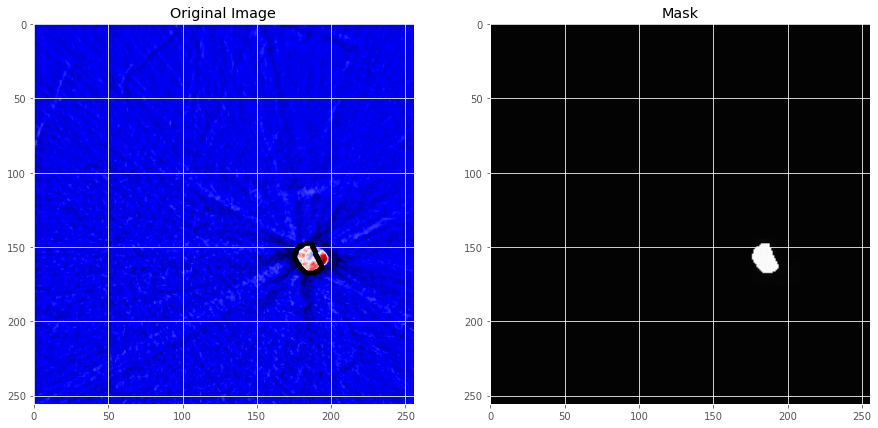

In [148]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # Aneurysm indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if Aneurysm
    # draw a boundary(contour) in the original image separating Aneurysm and non-Aneurystic areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Original Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [14]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [15]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [16]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    print('outputs.shape',outputs.shape)
    return model

In [17]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coef])

W0714 20:22:20.471674 140460243167040 deprecation_wrapper.py:119] From /home/emu/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 20:22:20.498631 140460243167040 deprecation_wrapper.py:119] From /home/emu/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 20:22:20.500529 140460243167040 deprecation_wrapper.py:119] From /home/emu/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0714 20:22:20.543109 140460243167040 deprecation_wrapper.py:119] From /home/emu/.conda/envs/keras/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please 

outputs.shape (?, 256, 256, 1)


In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 256, 256, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-anuerysm-all-data.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

<H2> Inference

In [19]:
# load the best model
model.load_weights('model-anuerysm-all-data.h5')

In [149]:
# Evaluate on validation set
model.evaluate(X_valid, y_valid, verbose=1)

175/175 [==============================] - 3s 20ms/step


[0.3550136205128261, 0.12796458550861903]

In [150]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

175/175 [==============================] - 3s 18ms/step


In [134]:
# Predict on Validation slices
preds_val_folder = model.predict(X_val, verbose=1)

220/220 [==============================] - 4s 19ms/step


In [135]:
# Threshold predictions for Validation slices
preds_val_folder_t = (preds_val_folder > 0.5).astype(np.uint8)

In [151]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [152]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))
        print(ix)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('True Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('True Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Mask Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Mask Predicted binary');

<H2> Predictions on Training Set


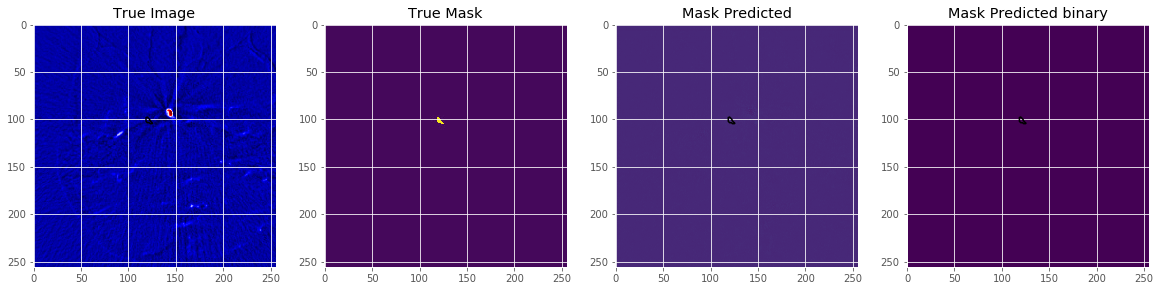

In [153]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

714


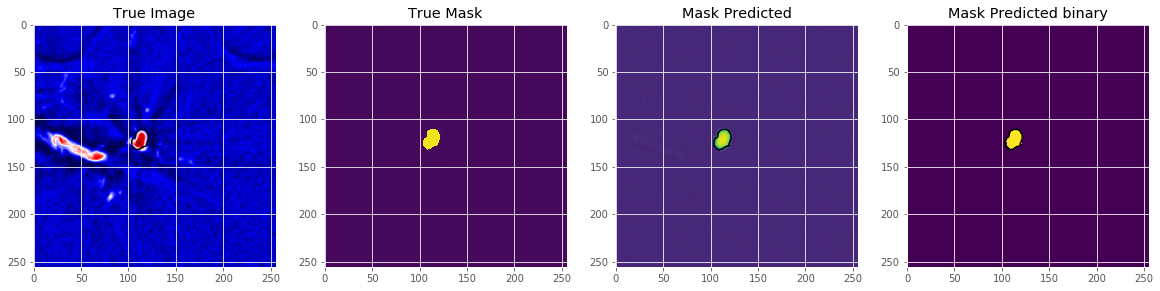

In [154]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

1190


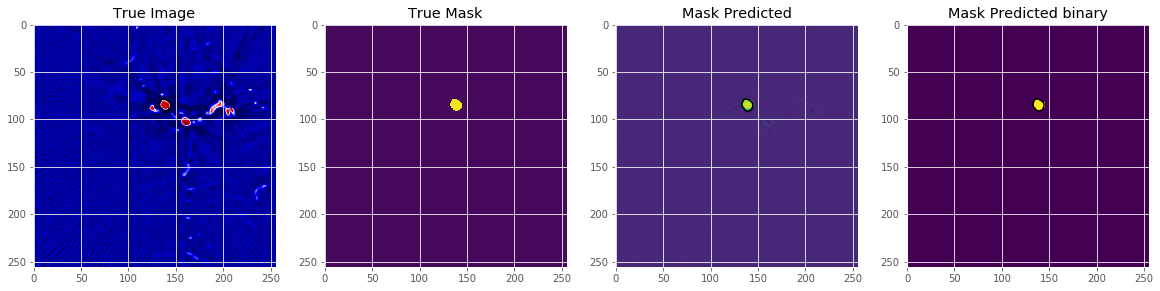

In [155]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

1210


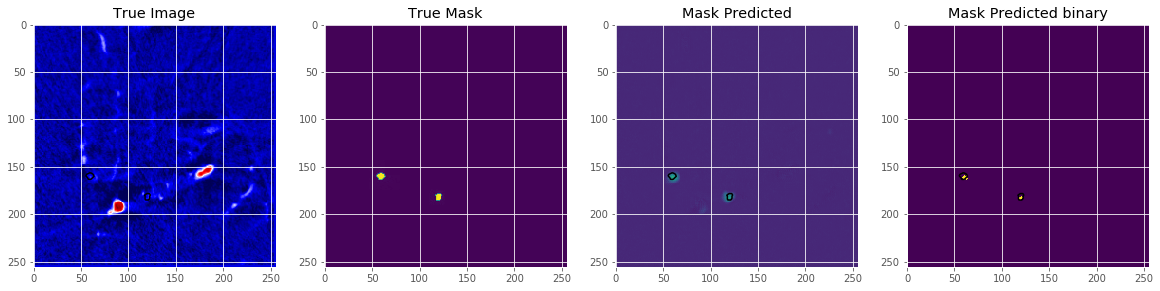

In [156]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

<H2> Predictions on Test Set

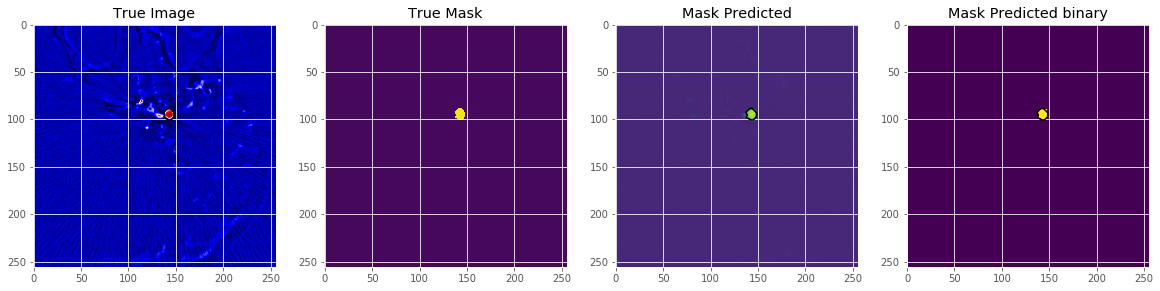

In [157]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

112


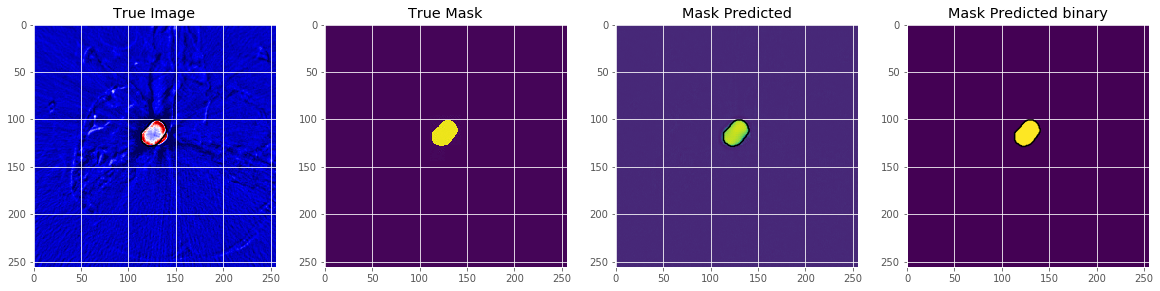

In [158]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

73


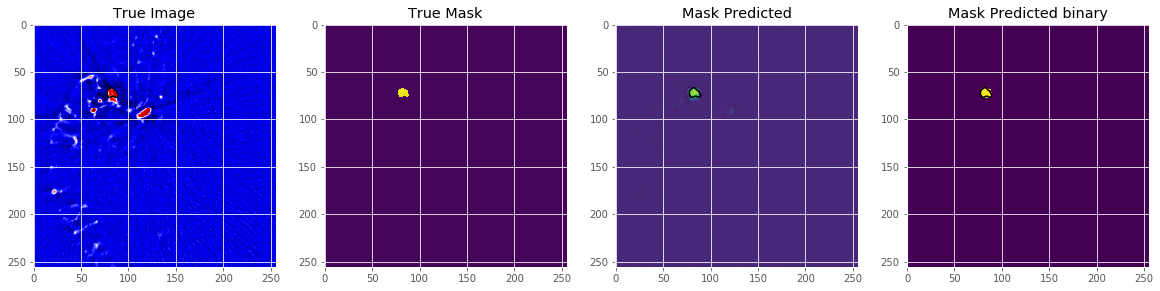

In [159]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

135


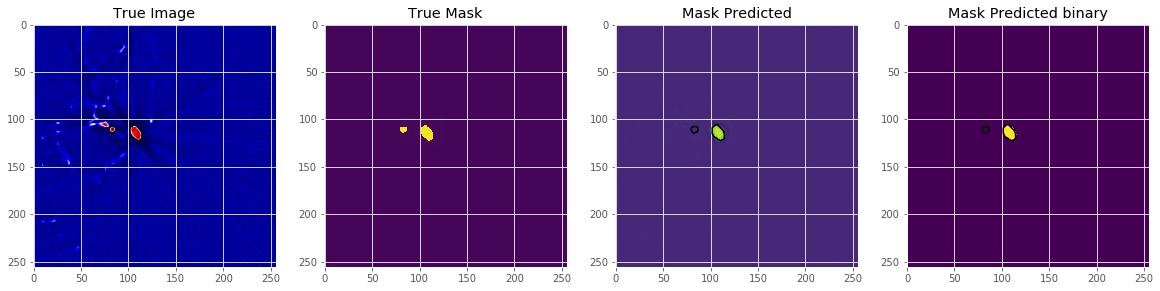

In [160]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [161]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [162]:
mse(y_valid[2], preds_val[1])

0.0005645595123966726

In [137]:
# Stitching back the slices 
destack_np= np.dstack((preds_val_folder_t[0],preds_val_folder_t[1]))
i=2
for i in range(218):
    destack_np= np.dstack((destack_np,preds_val_folder_t[i]))

In [63]:
destack_np_transposed.shape

(220, 256, 256)

In [138]:
destack_np_transposed=destack_np.transpose((2,0,1))
np.unique(destack_np_transposed[0])

array([0], dtype=uint8)

In [139]:
# Save numpy array prediction
np.save('destack_np_transposed_patient-7.npy',destack_np_transposed)

In [31]:
import ipyvolume as ipv

In [143]:
x, y, z = destack_np_transposed[0],destack_np_transposed[1], destack_np_transposed[2]
s = ipv.plot_mesh(x, y, z, wireframe=False)
#s.squarelim()
ipv.show()

In [191]:
ipv.quickvolshow(destack_np_transposed)
ipv.show()
print('done displaying')

done displaying
